# Basics

## Stellar Flyby Basics

A stellar flyby is when a star external to a planetary system passes by the system on a hyperbolic trajectory. The figure below shows four different examples of planar hyperbolic trajectories with different impact parameters and eccentricites passing by a Sun-Neptune system.

<img src="https://github.com/zyrxvo/airball/raw/main/docs/examples/images/hyperbolic_trajectories.png" alt="Hyperbolic trajectories with different impact parameters" height="396" width="426">

Like closed orbits, a hyperbolic trajectory can be defined by it's orbital elements. For example, the outermost trajectory has an impact parameter $b_\star=250$ AU and an eccentricity $e_\star=2.5$ (this gives a semi-major axis of $a_\star = -b_\star/\sqrt{e_\star^2 - 1} \approx -109$ AU). Note the negative semi-major axis.

Thus, if we wanted to setup a `REBOUND` simulation with these three objects it would be
```
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=5.15e-05, a=30.28, e=0.013)
sim.add(a=-109, e=2.5)
```
`REBOUND` will do a consistency check to make sure that if the eccentricity of an object is greater than 1 that its semi-major axis is also negative.

For a randomly oriented flyby star there are three main characteristics needed to compute the its initial conditions: the mass of the flyby star $m_\star$, the impact parameter $b_\star$, and the relative velocity or hyperbolic excess velocity $v_\star$. We found that these three parameters are the easiest to work with when drawing samples from distributions that define various stellar environments (see [Stellar Environments](./Stellar_Environments.ipynb) notebook for more details). ***However, it is important to note that converting from hyperbolic excess velocity $v_\star$ and impact parameter $b_\star$ to eccentricity $e_\star$ or periapsis $q_\star$ will depend on the total mass of the simulation.***

## Three-body system flyby (Sun-Neptune and flyby star).
As a basic example, we consider a stellar flyby to a Sun-Neptune system.

First we import `REBOUND`, `airball` `numpy`, and `matplotlib`. We also make sure to use a colour blind friendly palette.

In [1]:
import rebound
import numpy as np
import airball
import airball.units as u

import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.style as style
style.use('tableau-colorblind10')

### Define the parameters of the flyby star
We also define some useful constants and parameters for setting up our system. Additionally, we pick a set of parameters for our stellar flyby as a specific example. Recall that inclination (inc), argument of periapsis (omega), and longitude of the ascending node (Omega) are orbital elements and angles that define the orbital plane in 3D, see ref. [Wikipedia](https://en.wikipedia.org/wiki/Orbital_elements#Keplerian_elements). These angles are defined the same way even for hyperbolic trajectories.

In [2]:
pi = np.pi
twopi = 2.*pi

# Set the orbital elements of the flyby star
# Simulate a randomly oriented, 1 solar mass stellar flyby with relative velocity of 5 km/s, and an impact parameter of 120 AU.
star = airball.Star(m = 1 * u.solMass, b = 120 * u.au, v = 5 * u.km/u.s, inc = 0.72 * u.rad, omega = 0.19 * u.rad, Omega = 0.37 * u.rad, UNIT_SYSTEM=[u.deg])
star

<airball.stars.Star object at 0x103bbe890, m= 1 solMass, b= 120 AU, v= 5 km / s, inc= 41.25 deg, omega= 10.89 deg, Omega= 21.2 deg>

### Setup a two-body simulation and run a flyby simulation.
We define a function that returns a consistent `REBOUND` Simulation setup for convenience and reproducibility. We take the current values of Neptune's orbital elements.

In [3]:
def setup():
    # Set up a Sun-Neptune system.
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(m=5.151e-5, a=30.278, e=0.013, inc=0.031, omega=0, Omega=0, f=0)
    # sim.integrator = 'ias15'
    sim.move_to_com()
    return sim

#### The setup and the outcome.
Run the flyby simulation showing the details of the flyby setup with snapshots of the system before and after the flyby.

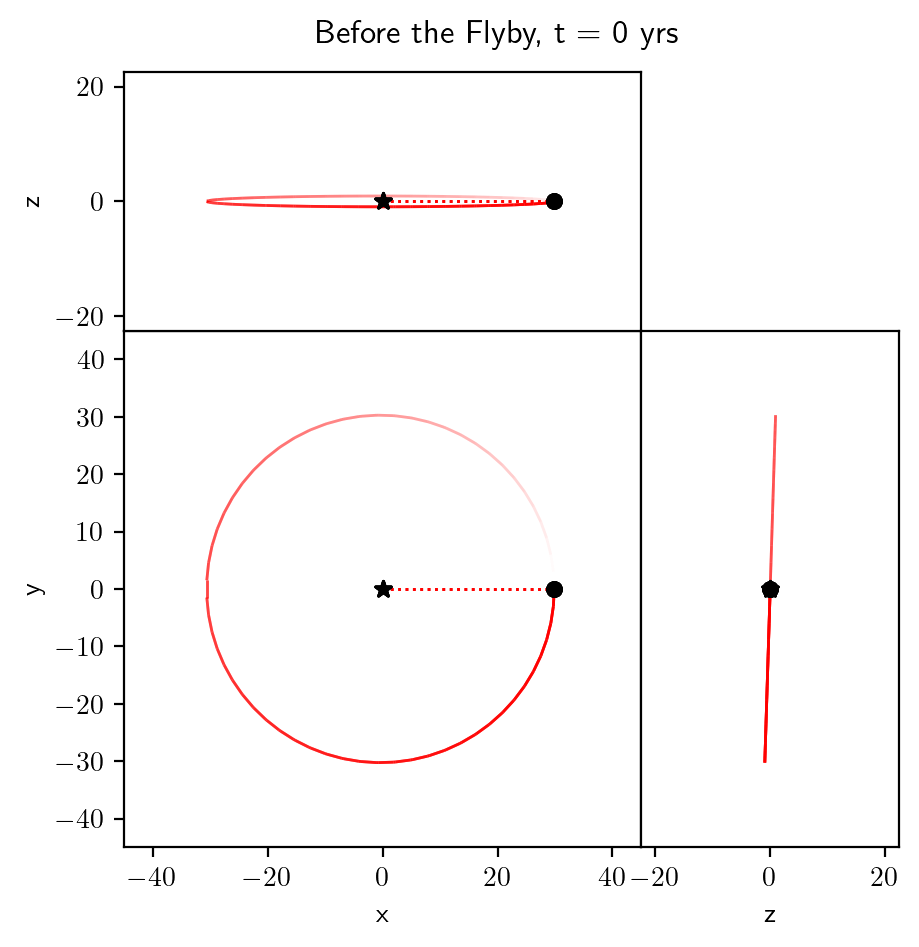

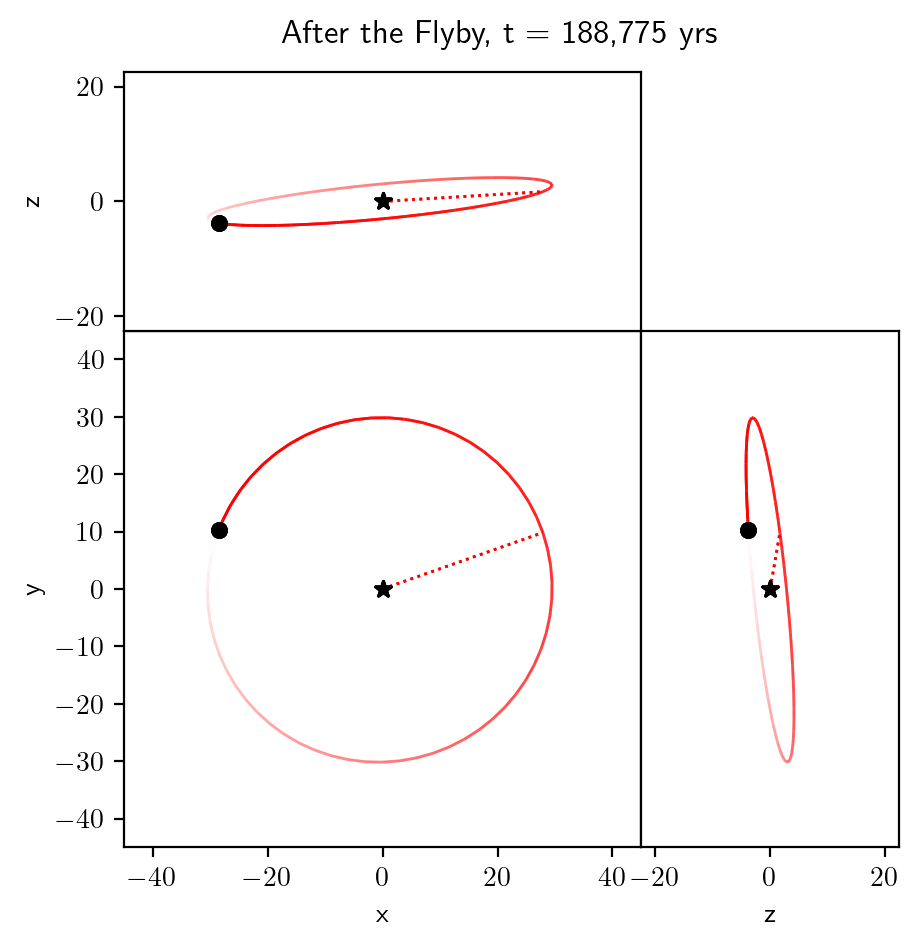

In [4]:
sim = setup()

sim.move_to_hel()
ops = rebound.OrbitPlotSet(sim, color=True, periastron=True, xlim=[-45,45], ylim=[-45,45])
ops.fig.suptitle(f'Before the Flyby, t = {sim.t/twopi:,.0f} yrs', y=0.77)
plt.show()

sim.move_to_com()
sim_after = airball.flyby(sim, star)

sim_after.move_to_hel()
ops = rebound.OrbitPlotSet(sim_after, color=True, periastron=True, xlim=[-45,45], ylim=[-45,45])
ops.fig.suptitle(f'After the Flyby, t = {sim_after.t/twopi:,.0f} yrs', y=0.77)
plt.show()

#### Investigate how the system changed.
We can see from the snapshots above that the system was perturbed. Thus, we can investigate what kind of an effect the flyby had on the planet's energy, semi-major axis, eccentricity, inclination, or whatever else we wanted.

In [5]:
Ei = sim.energy()
orb = sim.calculate_orbits()
ai = orb[0].a
ei = orb[0].e
Ii = orb[0].inc

Ef = sim_after.energy()
orb = sim_after.calculate_orbits()
af = orb[0].a
ef = orb[0].e
If = orb[0].inc

dE = np.abs((Ef-Ei)/Ei)
da = np.abs((af-ai)/ai)
de = np.abs((ef-ei)/ei)
dI = np.abs((If-Ii)/Ii)

print('Relative Changes:')
print(f'dE/E = {dE:8.5g}')
print(f'da/a = {da:8.5g}')
print(f'de/e = {de:8.5g}')
print(f'dI/I = {dI:8.5g}')

Relative Changes:
dE/E = 0.003915
da/a = 0.0039497
de/e =  0.37294
dI/I =   3.4827


If you wanted to see what the system looked like when the flyby star was at periapsis you could add it to the REBOUND simulation yourself and integrate it yourself.

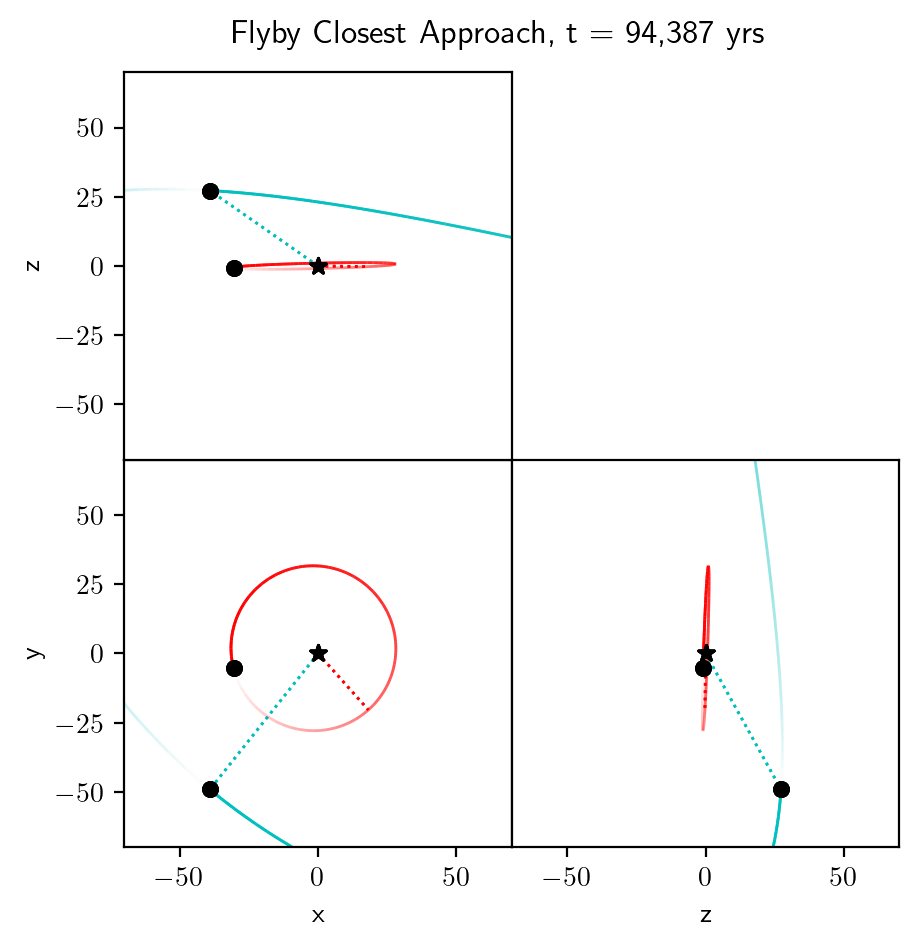

In [6]:
sim = setup()
airball.add_star_to_sim(sim, star)
tperi = sim.particles['flybystar'].T
sim.integrate(tperi)

sim.move_to_hel()
ops = rebound.OrbitPlotSet(sim, color=True, periastron=True, xlim=[-70,70], ylim=[-70,70], slices=1)
ops.fig.suptitle(f'Flyby Closest Approach, t = {sim.t/twopi:,.0f} yrs', y=0.77)
plt.show()

## Multiple Flybys
We can easily investigate the effects that different flybys would have on a given system, or the effects that successive flybys would have on a given system.

### Orientation
Let us first investigate the effect that the orientation of a flyby has on a system's energy. To do this, we'll create a set of Stars that all have the same mass, impact parameter and velocity, but with random inclination angles. We'll use the same $m$, $b$, and $v$ as our original star. The `airball.Stars` object won't show you all of the stars in it unless you iterate through it. It does this for speed. We'll also sort the stars by their inclination.

In [7]:
Nstars = 1000
stars = airball.Stars(m=star.m, b=star.b, v=star.v, inc='uniform', omega=star.omega, Omega=star.Omega, size=Nstars)
stars.sortby('inc')
stars

If we're considering how different flybys alter the a given simulation, then we can run them all in parallel using the `airball.flybys` command. If we provide only one `REBOUND` simulation then `airball` will duplicate it for us to match the number of stars we provide. This may take up to a minute or so to run depending on the speed of your computer.

In [8]:
sim = setup()
after_sims = airball.flybys(sim, stars)

We can see that the inclination of the flyby can make a big difference in some cases.

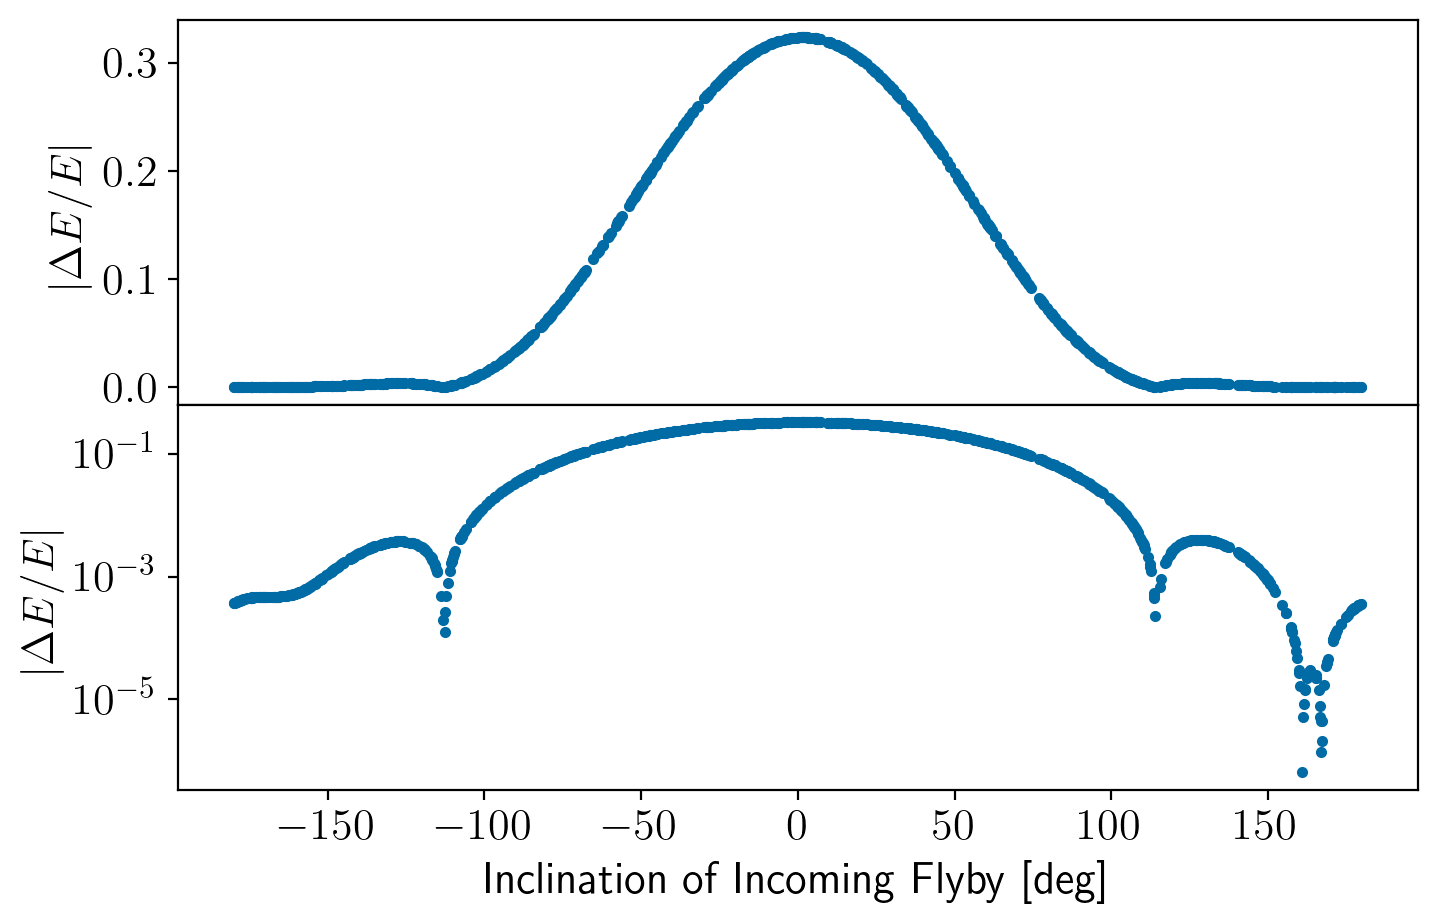

In [9]:
dEs = np.zeros(Nstars)
for i in range(Nstars):
    dEs[i] = np.abs((after_sims[i].energy() - sim.energy())/sim.energy())

plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(2,1, figsize=(8,5), sharex=True)
ax[0].plot(stars.inc.to(u.deg), dEs, '.')
ax[1].plot(stars.inc.to(u.deg), dEs, '.')
ax[1].set_yscale('log')
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[1].set_ylabel(r'$|\Delta E/E|$')
ax[1].set_xlabel(r'Inclination of Incoming Flyby [deg]')
plt.subplots_adjust(hspace=0.)
plt.show()

### Periapsis
We can also investigate the effect that the closest approach that a flyby has on a system's energy. To do this, we'll create a set of identical Stars that only differ by how close they come to our Sun-Neptune system. We'll spread the perihelia evenly logarithmically, but we'll need to compute the impact parameters ourselves since perihelion depends on which simulation we use.

In [12]:
Nstars = 1000
sim = setup()
q_stars = np.logspace(-0.5, 2, Nstars) * sim.particles[1].a
mu = airball.tools.gravitational_mu(sim, star)
b_stars = airball.tools.vinf_and_q_to_b(mu, q_stars, star.v)

stars = airball.Stars(m=star.m, b=b_stars, v=star.v, inc=star.inc, omega=star.omega, Omega=star.Omega)
stars.sortby('q', sim)
stars

In [13]:
sim = setup()
after_sims = airball.flybys(sim, stars)

We can see that there is an exponential dependence on the periapsis of the flyby. We can compare this to the analytical theory for adiabatic encounters.

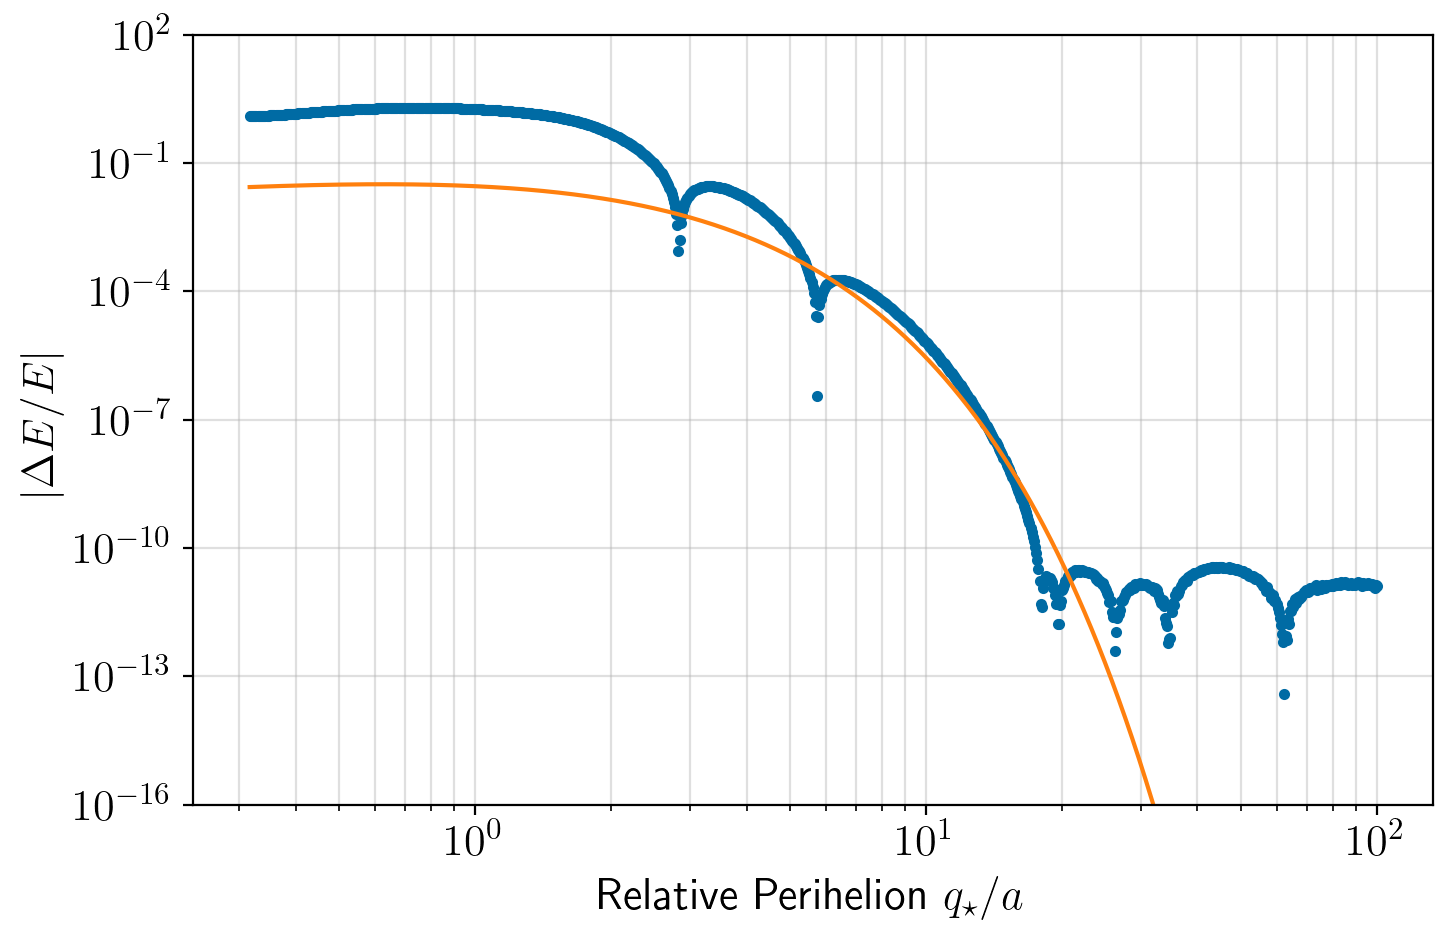

In [14]:
dEs = np.zeros(Nstars)
for i in range(Nstars):
    dEs[i] = np.abs((after_sims[i].energy() - sim.energy())/sim.energy())

plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(1,1, figsize=(8,5), sharex=True)
ax.loglog(stars.q(sim)/sim.particles[1].a, dEs, '.')
ax.loglog(stars.q(sim)/sim.particles[1].a, airball.relative_energy_change(sim, stars))
ax.grid(which='both', alpha=0.4)
ax.set_ylim([1e-16, 1e2])
ax.set_ylabel(r'$|\Delta E/E|$')
ax.set_xlabel(r'Relative Perihelion $q_\star/a$')
plt.show()

## Making Hyperbolic Trajectories Figure

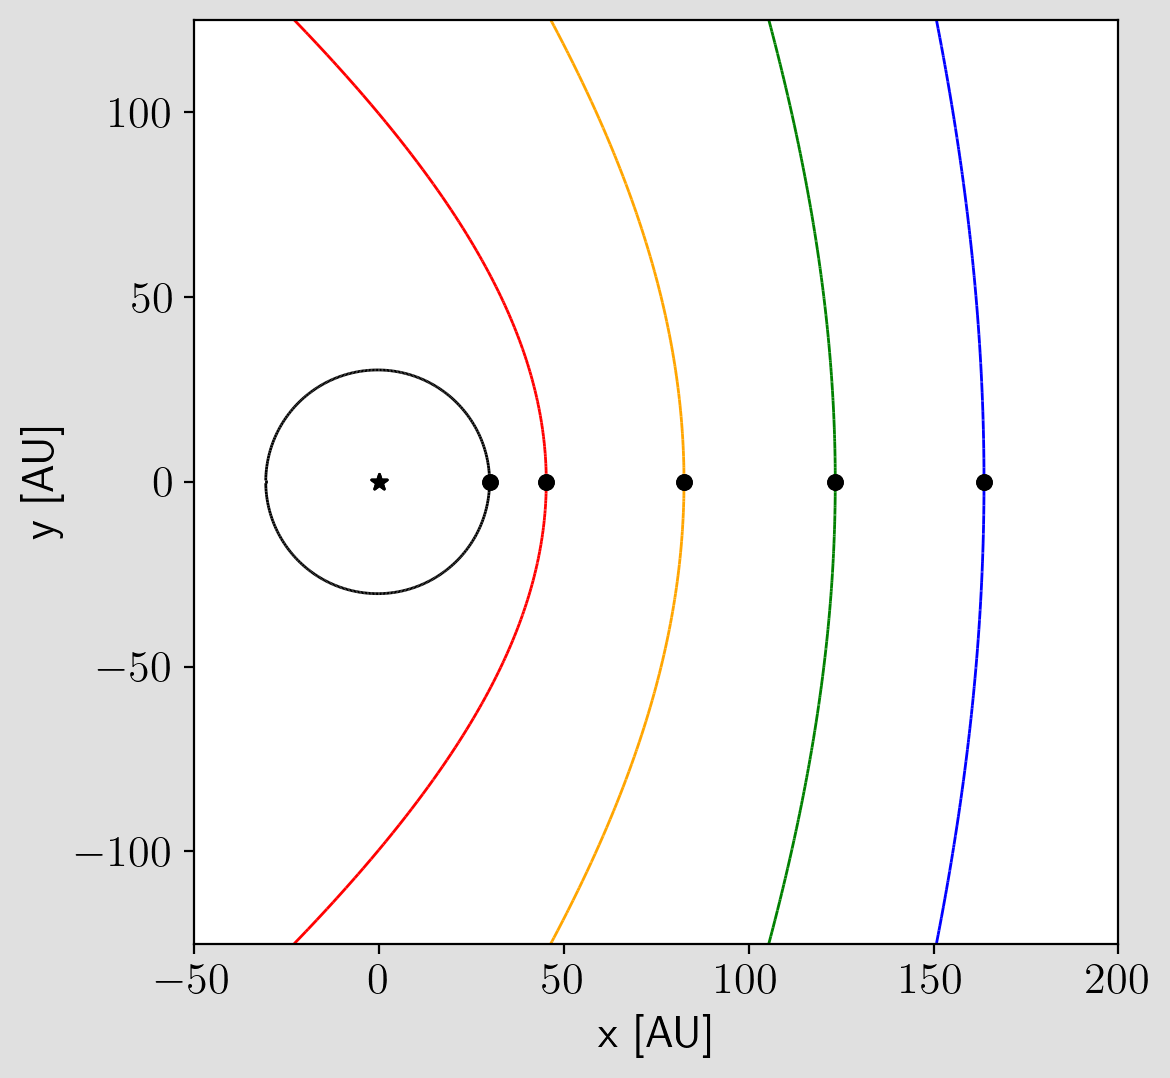

In [15]:
def be2a(b,e): return -b/np.sqrt(e**2. - 1.)

bs = [150, 200, 200, 250]
es = [1.2, 1.41, 2.23, 2.5]

sim = setup()
for b,e in zip(bs,es):
    sim.add(a=be2a(b,e), e=e)

plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(1,1, figsize=(6,6))
rebound.OrbitPlot(sim, fig=fig, ax=ax, xlim=[-50,200], ylim=[-125,125], color=['black', 'red', 'orange', 'green', 'blue'], orbit_style="solid", unitlabel="[AU]", Narc=512)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
fig.patch.set_facecolor('#E0E0E0')
plt.gca().set_aspect('equal')
plt.savefig('images/hyperbolic_trajectories.png', dpi=192, facecolor=fig.get_facecolor(), edgecolor='none', pad_inches=0.5, bbox_inches='tight')
plt.show()